## Standardize molecules

In [7]:
import pandas as pd
import numpy as np
import random
from rdkit.Chem import AllChem
from rdkit import RDLogger

from sklearn.manifold import TSNE
from rdkit.Chem import MolFromSmiles, DataStructs, rdMolDescriptors
import matplotlib.pyplot as plt
import seaborn as sns



RDLogger.DisableLog('rdApp.*')

seed_value = 123

np.random.seed(seed_value)
random.seed(seed_value)

In [2]:
def generate_similarities(smiles):
    fps = []
    similarities_list = []
    for smiles in smiles:
        fp = AllChem.GetMorganFingerprintAsBitVect(MolFromSmiles(smiles), 2, 2048)
        #fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(MolFromSmiles(smiles), 
                                                                    #nBits=2048, includeChirality = True)
        fps.append(fp)
    
    if len(fps) > 10000:
        entries = 10000
    else:
        entries = len(fps)
        
    for i in range(0,entries):
        
        remaining_fp = fps[:i] + fps[i+1:]
        similarities = DataStructs.BulkTanimotoSimilarity(fps[i], remaining_fp)
        similarities.insert(i,1)
        similarities_list.append(similarities)
        
    return np.transpose(np.array(similarities_list))

In [10]:
def get_molecules_per_coordinates(df,sweeteners_dataset,x0,x1,y0,y1, class_label):
    
    cluster_molecules = []
    labels = sweeteners_dataset["y"]
    for i, coord in enumerate(df):
        if x0 < coord[0] < x1 and y0 < coord[1] < y1 and labels[i] == class_label:
            cluster_molecules.append(sweeteners_dataset.at[i,"mols"])
            
    return cluster_molecules

from rdkit import DataStructs

def get_similarity(query_seq, cluster_molecules):
    fps = []
    for mol in cluster_molecules:
        fp = AllChem.GetMorganFingerprintAsBitVect(MolFromSmiles(mol),2,nBits=2048)
        fps.append(fp)

    query_fp = \
    AllChem.GetMorganFingerprintAsBitVect(MolFromSmiles(query_seq),2,nBits=2048)

    scores = DataStructs.BulkTanimotoSimilarity(query_fp, fps)
    return np.mean(scores)

from rdkit.Chem import MolFromSmarts

def highlight_atoms_with_query(lst,smarts):
    to_highlight = []
    for mol in lst:
        mol = MolFromSmiles(mol)
        final_tuple = ()
        lst_idx = mol.GetSubstructMatches(smarts)
        for idx in lst_idx:
            final_tuple = final_tuple + idx


        to_highlight.append(final_tuple)
    return to_highlight

def get_percentage_carbohydrate_monomer(cluster_molecules):
    
    smarts = MolFromSmarts("[Or5,Or6,Or7,Or8]")
    counter = 0
    for mol in cluster_molecules:
        mol = MolFromSmiles(mol)
        isMonossacharide = mol.HasSubstructMatch(smarts)
        if isMonossacharide:
            counter+=1
    
    return counter/len(cluster_molecules), counter, len(cluster_molecules) 

def get_percentage_amino_acid(cluster_molecules):
    
    smarts = MolFromSmarts("[NX3,NX4+][CX4H]([*])[CX3](=[OX1])[O,N]")
    counter = 0
    for mol in cluster_molecules:
        mol = MolFromSmiles(mol)
        isPeptide = mol.HasSubstructMatch(smarts)
        if isPeptide:
            counter+=1
    
    return counter/len(cluster_molecules), counter, len(cluster_molecules) 


## Test set

In [8]:
test_sweeteners_dataset = pd.read_csv("../resources/models/test_dataset.csv")
test_similarities = generate_similarities(test_sweeteners_dataset["mols"])

test_tsne_df = TSNE(n_components=2,random_state=123).fit_transform(test_similarities)

/home/joao/anaconda3/envs/deepsweet/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/joao/anaconda3/envs/deepsweet/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/home/jcapela/miniconda3/envs/sweeteners_paper5/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


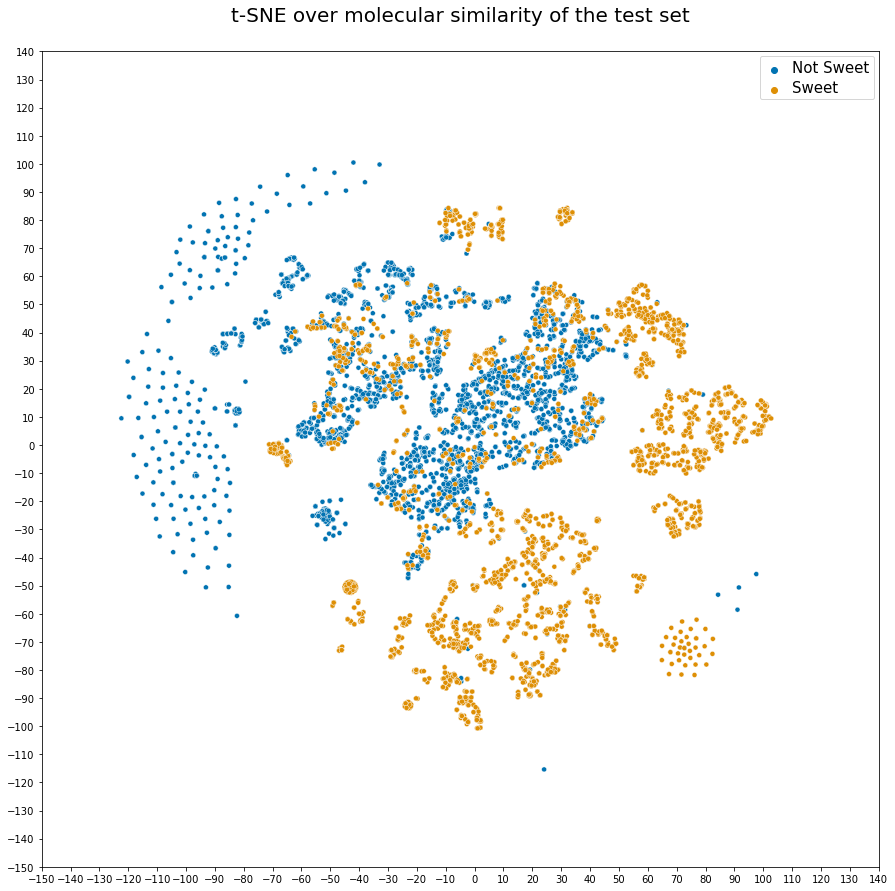

<Figure size 1080x1080 with 0 Axes>

In [59]:

labels = test_sweeteners_dataset.loc[:,"y"]
string_labels = []
for label in labels:
    if label == 1:
        string_labels.append("Sweet")
    else:
        string_labels.append("Not Sweet")
    
fig, ax = plt.subplots()
plt.figure(figsize=(15, 15))
scatter_plot = sns.scatterplot(
    test_tsne_df[:, 0], test_tsne_df[:, 1],
    hue=string_labels,
    palette=sns.color_palette("colorblind", 2),
    legend="full",
    s=25,
    ax=ax
)
ax.set_title("t-SNE over molecular similarity of the test set", 
                       fontdict= { 'fontsize': 20 }, pad= 30)

plt.setp(ax.get_legend().get_texts(), fontsize='15')
ax.set_xticks(range(-150,150,10))
ax.set_yticks(range(-150,150,10))
fig.set_size_inches(15,15)
plt.show()

In [11]:
sweeteners_blend_test_set = get_molecules_per_coordinates(test_tsne_df,test_sweeteners_dataset,-80,50,-50,80, 1)
len(sweeteners_blend_test_set)

1431

In [12]:
non_sweeteners_blend_test_set = get_molecules_per_coordinates(test_tsne_df,test_sweeteners_dataset,-80,50,-50,80, 0)
len(non_sweeteners_blend_test_set)
np.random.seed_value = 123
non_sweeteners_blend_test_set = list(np.random.choice(non_sweeteners_blend_test_set, 1441, replace=False))

In [159]:
from pandas import DataFrame

df1 = DataFrame(columns=["smiles","y"])
df1["smiles"] = sweeteners_blend_test_set
df1["y"] = [1] * len(sweeteners_blend_test_set)
df2 = DataFrame(columns=["smiles","y"])
df2["smiles"] = non_sweeteners_blend_test_set
df2["y"] = [0] * len(non_sweeteners_blend_test_set)

df = df1.append(df2)
df.to_csv("../resources/data/blend_test_set.csv", index=True)